## Description:
Learns a koopman operator for the time evolution of the flame field. It uses an autoencoder style of NN architecture to encode the data X into a latent space Z. It then learns a matrix which progresses the field to the next time step (Z_t+1 = K Z_t). It then decodes the prediction back to the original data space X_t+1.


In [1]:
from __future__ import annotations
from pathlib import Path
import os
os.chdir("../../..")
import yaml

from flamekit.io_fields import field_path, FIELD_HDF_KEY
from flamekit.io_fronts import Case
import numpy as np
import pandas as pd

import torch
import torch.nn as nn
import torch.optim as optim
from mpi4py import MPI


import matplotlib.pyplot as plt
import matplotlib.tri as mtri
comm = MPI.COMM_WORLD
rank = comm.rank



In [2]:

PROJECT_ROOT = Path.cwd().resolve()
CONFIG_PATH = PROJECT_ROOT / "notebooks" / "case_studies/KoopmanAE" / "KoopmanAE.yaml"
CFG = yaml.safe_load(CONFIG_PATH.read_text(encoding="utf-8"))

# ----------------------------
# USER SETTINGS (from YAML)
# ----------------------------
TIME_STEP_START = int(CFG["TIME_STEP_START"])
TIME_STEP_END = int(CFG["TIME_STEP_END"])

PHI = float(CFG["PHI"])
LAT_SIZE = str(CFG["LAT_SIZE"])
POST = bool(CFG["POST"])

BASE_DIR = PROJECT_ROOT / Path(CFG["BASE_DIR"])
VAR_NAME = str(CFG["VAR_NAME"])
SORT_COLS = list(CFG["SORT_COLS"])
COORD_TOL = float(CFG["COORD_TOL"])

# Remove temporal mean before normalization
REMOVE_MEAN = bool(CFG.get("REMOVE_MEAN", True))

CONTOUR_LEVELS_FILLED = int(CFG.get("CONTOUR_LEVELS_FILLED", 60))

X_THRESHOLD = float(CFG["X_THRESHOLD"])  # keep only x > threshold


# ----------------------------
# Helpers
# ----------------------------
def field_hdf5_path(base_dir: Path, phi: float, lat_size: str, time_step: int, post: bool) -> Path:
    case = Case(
        base_dir=base_dir,
        phi=phi,
        lat_size=lat_size,
        time_step=time_step,
        post=post,
    )
    return field_path(case)

def read_field_sorted(path: Path, var_name: str, sort_cols: list[str]) -> tuple[np.ndarray, np.ndarray]:
    if not path.exists():
        raise FileNotFoundError(f"Missing file:\n  {path}")
    df = pd.read_hdf(path, key=FIELD_HDF_KEY)

    missing = [c for c in (sort_cols + [var_name]) if c not in df.columns]
    if missing:
        raise ValueError(f"{path.name}: missing columns {missing}")

    df = df.replace([np.inf, -np.inf], np.nan).dropna(subset=sort_cols + [var_name])
    df = df.sort_values(sort_cols, kind="mergesort").reset_index(drop=True)

    coords = df[sort_cols].to_numpy(dtype=np.float64)
    values = df[var_name].to_numpy(dtype=np.float64)
    return coords, values

# ----------------------------
# Build X: (n_points_cropped, n_snaps)
# ----------------------------
times = list(range(TIME_STEP_START, TIME_STEP_END + 1))

ref_path = field_hdf5_path(BASE_DIR, PHI, LAT_SIZE, times[0], POST)
coords_ref_full, snap0_full = read_field_sorted(ref_path, VAR_NAME, SORT_COLS)

x_ref = coords_ref_full[:, 0]
mask_x = x_ref > X_THRESHOLD

coords_ref = coords_ref_full[mask_x]
snap0 = snap0_full[mask_x]

n_points = coords_ref.shape[0]
n_snaps = len(times)

if rank == 0:
    print(f"Reference timestep: {times[0]}")
    print(f"X_THESHOLD={X_THRESHOLD} -> keeping {n_points}/{coords_ref_full.shape[0]} points")
    print(f"n_points={n_points}, n_snapshots={n_snaps}")
    print(f"Reading: {ref_path}")

snapshots = [snap0]
for t in times[1:]:
    path = field_hdf5_path(BASE_DIR, PHI, LAT_SIZE, t, POST)
    coords_t_full, snap_t_full = read_field_sorted(path, VAR_NAME, SORT_COLS)

    if coords_t_full.shape[0] != coords_ref_full.shape[0]:
        raise ValueError(
            f"Inconsistent n_points (full) at timestep {t}: {coords_t_full.shape[0]} vs {coords_ref_full.shape[0]}"
        )

    if COORD_TOL == 0.0:
        same = np.array_equal(coords_t_full, coords_ref_full)
    else:
        same = np.allclose(coords_t_full, coords_ref_full, atol=COORD_TOL, rtol=0.0)

    if not same:
        raise ValueError(
            f"Coordinates mismatch at timestep {t}.\n"
            f"Set COORD_TOL>0 or interpolate/regrid."
        )

    snap_t = snap_t_full[mask_x]
    if snap_t.shape[0] != n_points:
        raise RuntimeError("Masking produced inconsistent point count. Check X_THESHOLD and sorting.")

    snapshots.append(snap_t)

X = np.stack(snapshots, axis=1).astype(np.float64)  # (n_points, n_snaps)


Reference timestep: 200
X_THESHOLD=330.0 -> keeping 179200/839680 points
n_points=179200, n_snapshots=100
Reading: /media/alexandros/OS/Users/alexp/Documents/Bachelor Thesis/Code/data/fields/unstructured/phi0.40/h400x025_ref/extracted_field_200.hdf5


In [3]:
DEVICE = str(CFG["DEVICE"])
DT = float(CFG["DT"])

DROPOUT = float(CFG["DROPOUT"])

OFFLOAD_MODEL_TO_CPU = bool(CFG["OFFLOAD_MODEL_TO_CPU"])

USE_PCA = bool(CFG["USE_PCA"])
PCA_DIM = int(CFG["PCA_DIM"])

Z_DIM = int(CFG["Z_DIM"])
ENC_HIDDEN = tuple(CFG["ENC_HIDDEN"])
DEC_HIDDEN = tuple(CFG["DEC_HIDDEN"])

EPOCHS = int(CFG["EPOCHS"])
BATCHES_PER_EPOCH = int(CFG["BATCHES_PER_EPOCH"])
BATCH_SIZE = int(CFG["BATCH_SIZE"])
ROLLOUT_LEN = int(CFG["ROLLOUT_LEN"])

LR = float(CFG["LR"])
WEIGHT_DECAY = float(CFG["WEIGHT_DECAY"])

W_RECON = float(CFG["W_RECON"])
W_PRED = float(CFG["W_PRED"])
W_LAT = float(CFG["W_LAT"])
W_STAB = float(CFG["W_STAB"])

SEED = int(CFG["SEED"])
# ----------------------------
np.random.seed(SEED)
torch.manual_seed(SEED)

if DEVICE == "cuda" and not torch.cuda.is_available():
    DEVICE = "cpu"
device = torch.device(DEVICE)

if rank == 0:
    print("Using device:", device)
    if device.type == "cuda":
        print("GPU:", torch.cuda.get_device_name(0))


def optimizer_to(optimizer: optim.Optimizer, device: torch.device) -> None:
    for state in optimizer.state.values():
        for k, v in state.items():
            if torch.is_tensor(v):
                state[k] = v.to(device)

# Arrange as (T, n_points)
X_seq = X.T.astype(np.float32)  # (T, n_points)

# Normalize per spatial DOF over time
if REMOVE_MEAN:
    X_mean = X_seq.mean(axis=0, keepdims=True)
else:
    X_mean = np.zeros((1, X_seq.shape[1]), dtype=X_seq.dtype)
X_std  = X_seq.std(axis=0, keepdims=True) + 1e-6
Xn_seq = (X_seq - X_mean) / X_std

# Optional PCA
if USE_PCA:
    from sklearn.decomposition import PCA
    pca_ncomp = int(min(PCA_DIM, Xn_seq.shape[1]))
    if pca_ncomp < 1:
        raise ValueError("PCA_DIM too small after min(PCA_DIM, n_snaps, n_points).")
    pca = PCA(n_components=pca_ncomp, svd_solver="auto", random_state=SEED)
    Xp_seq = pca.fit_transform(Xn_seq)  # (T, pca_dim)
    if rank == 0:
        evr = float(np.sum(pca.explained_variance_ratio_))
        print(f"PCA: n_components={pca_ncomp}, explained_var_sum={evr:.4f}")
else:
    pca = None
    Xp_seq = Xn_seq

x_dim = Xp_seq.shape[1]
T_total = Xp_seq.shape[0]
if ROLLOUT_LEN >= T_total:
    raise ValueError(f"ROLLOUT_LEN={ROLLOUT_LEN} must be < number of snapshots T={T_total}.")

Xp_torch = torch.from_numpy(Xp_seq)  # keep on CPU; move batches to GPU

def build_mlp(in_dim: int, hidden: tuple[int, ...], out_dim: int, dropout: float) -> nn.Sequential:
    layers: list[nn.Module] = []
    prev = in_dim
    for h in hidden:
        layers.append(nn.Linear(prev, h))
        layers.append(nn.Tanh())
        if dropout > 0.0:
            layers.append(nn.Dropout(p=dropout))
        prev = h
    layers.append(nn.Linear(prev, out_dim))
    return nn.Sequential(*layers)

class DeepKoopman(nn.Module):
    def __init__(self, x_dim: int, z_dim: int, enc_hidden: tuple[int, ...], dec_hidden: tuple[int, ...]) -> None:
        super().__init__()
        self.enc = build_mlp(x_dim, enc_hidden, z_dim, DROPOUT)
        self.dec = build_mlp(z_dim, dec_hidden, x_dim, DROPOUT)
        self.K = nn.Parameter(torch.eye(z_dim))  # linear Koopman operator

    def encode(self, x: torch.Tensor) -> torch.Tensor:
        return self.enc(x)

    def decode(self, z: torch.Tensor) -> torch.Tensor:
        return self.dec(z)

    def step_latent(self, z: torch.Tensor) -> torch.Tensor:
        return z @ self.K.T

def spectral_radius(K: torch.Tensor) -> torch.Tensor:
    eigvals = torch.linalg.eigvals(K)
    return torch.max(torch.abs(eigvals)).real

def sample_batch_indices(T: int, rollout_len: int, batch_size: int) -> list[int]:
    max_start = T - (rollout_len + 1)
    if max_start < 0:
        raise ValueError(f"Not enough snapshots: T={T}, rollout_len={rollout_len}")
    return np.random.randint(0, max_start + 1, size=batch_size).tolist()

def make_batch(Xp_seq_torch: torch.Tensor, idx0: list[int], rollout_len: int) -> torch.Tensor:
    seqs = [Xp_seq_torch[i : i + rollout_len + 1] for i in idx0]
    return torch.stack(seqs, dim=0)  # (B, L+1, x_dim)

model = DeepKoopman(x_dim=x_dim, z_dim=Z_DIM, enc_hidden=ENC_HIDDEN, dec_hidden=DEC_HIDDEN).to(device)
opt = optim.Adam(model.parameters(), lr=LR, weight_decay=WEIGHT_DECAY)
mse = nn.MSELoss()

if rank == 0:
    print(f"Training DeepKoopman: x_dim={x_dim}, z_dim={Z_DIM}, T={T_total}, rollout_len={ROLLOUT_LEN}")

for epoch in range(1, EPOCHS + 1):
    model.train()
    losses = []

    for _ in range(BATCHES_PER_EPOCH):
        idx0 = sample_batch_indices(T_total, ROLLOUT_LEN, batch_size=BATCH_SIZE)
        Xb = make_batch(Xp_torch, idx0, ROLLOUT_LEN).to(device)  # (B, L+1, x_dim)

        B, Lp1, _ = Xb.shape
        L = Lp1 - 1

        z_true = model.encode(Xb.reshape(B * (L + 1), x_dim)).reshape(B, L + 1, Z_DIM)

        # Recon
        X_recon = model.decode(z_true.reshape(B * (L + 1), Z_DIM)).reshape(B, L + 1, x_dim)
        loss_recon = mse(X_recon, Xb)

        # Latent rollout from z0
        z_list = [z_true[:, 0, :]]
        for _k in range(L):
            z_list.append(model.step_latent(z_list[-1]))
        z_pred = torch.stack(z_list, dim=1)  # (B, L+1, Z_DIM)

        X_pred = model.decode(z_pred.reshape(B * (L + 1), Z_DIM)).reshape(B, L + 1, x_dim)

        loss_pred = mse(X_pred[:, 1:, :], Xb[:, 1:, :])
        loss_lat  = mse(z_pred[:, 1:, :], z_true[:, 1:, :])

        rho = spectral_radius(model.K)
        loss_stab = torch.relu(rho - 1.0) ** 2

        loss = W_RECON * loss_recon + W_PRED * loss_pred + W_LAT * loss_lat + W_STAB * loss_stab

        opt.zero_grad(set_to_none=True)
        loss.backward()
        opt.step()

        losses.append(loss.item())

        # Release batch tensors explicitly to free GPU memory
        del Xb, z_true, z_list, X_recon, z_pred, X_pred, loss_recon, loss_pred, loss_lat, loss_stab, loss, rho

    if device.type == "cuda":
        torch.cuda.empty_cache()

    if rank == 0 and (epoch == 1 or epoch % 20 == 0):
        avg = float(np.mean(losses)) if losses else float("nan")
        with torch.no_grad():
            rho_val = float(spectral_radius(model.K).cpu().item())
        print(f"Epoch {epoch:5d}/{EPOCHS} | loss={avg:.6e} | rho(K)={rho_val:.6f}")

# ----------------------------
# One-step forecast at next timestep
# ----------------------------
model.eval()
t_next = times[-1] + 1

with torch.no_grad():
    x_last = Xp_torch[-1, :].unsqueeze(0).to(device)  # (1, x_dim)
    z_last = model.encode(x_last)          # (1, z_dim)
    z_next = model.step_latent(z_last)     # (1, z_dim)
    x_next_p = model.decode(z_next).cpu().numpy()[0]  # (x_dim,)

# Free inference tensors and optionally move model off GPU
del x_last, z_last, z_next
if device.type == "cuda":
    torch.cuda.empty_cache()

if OFFLOAD_MODEL_TO_CPU and device.type == "cuda":
    model.to("cpu")
    optimizer_to(opt, torch.device("cpu"))
    torch.cuda.empty_cache()

# Undo PCA + normalization
if USE_PCA:
    x_next_norm = pca.inverse_transform(x_next_p.reshape(1, -1))[0]
else:
    x_next_norm = x_next_p

x_next_pred = (x_next_norm * X_std.reshape(-1) + X_mean.reshape(-1)).astype(np.float64)  # (n_points,)

# ------------------------------------------------------------
# BC metrics for prediction (Dirichlet left, Neumann right, periodic top/bottom)
# ------------------------------------------------------------
x_bc = coords_ref[:, 0].astype(float)
y_bc = coords_ref[:, 1].astype(float)

x_min = float(np.min(x_bc))
x_max = float(np.max(x_bc))
y_min = float(np.min(y_bc))
y_max = float(np.max(y_bc))

x_span = float(np.ptp(x_bc)) or 1.0
y_span = float(np.ptp(y_bc)) or 1.0
bc_tol_x = 1e-6 * x_span
bc_tol_y = 1e-6 * y_span

left_idx = np.where(np.isclose(x_bc, x_min, atol=bc_tol_x))[0]
right_idx = np.where(np.isclose(x_bc, x_max, atol=bc_tol_x))[0]
top_idx = np.where(np.isclose(y_bc, y_max, atol=bc_tol_y))[0]
bottom_idx = np.where(np.isclose(y_bc, y_min, atol=bc_tol_y))[0]

left_target = None
if left_idx.size:
    left_target = float(np.mean(X[left_idx, :]))

top_bottom_pairs = []
if top_idx.size and bottom_idx.size:
    for i in top_idx:
        dx = np.abs(x_bc[bottom_idx] - x_bc[i])
        j = bottom_idx[int(np.argmin(dx))]
        if dx.min() <= bc_tol_x:
            top_bottom_pairs.append((i, j))
top_bottom_pairs = np.asarray(top_bottom_pairs, dtype=int)

right_pairs = []
if right_idx.size:
    for i in right_idx:
        same_y = np.where(np.isclose(y_bc, y_bc[i], atol=bc_tol_y) & (x_bc < x_max - bc_tol_x))[0]
        if same_y.size == 0:
            continue
        j = same_y[np.argmax(x_bc[same_y])]
        if x_bc[i] - x_bc[j] > 0:
            right_pairs.append((i, j))
right_pairs = np.asarray(right_pairs, dtype=int)

def _bc_metrics(values):
    metrics = {}
    if left_idx.size:
        left_vals = values[left_idx]
        if left_target is not None:
            metrics["dirichlet_left_rmse"] = float(np.sqrt(np.mean((left_vals - left_target) ** 2)))
        metrics["dirichlet_left_std"] = float(np.std(left_vals))
    if right_pairs.size:
        dx = x_bc[right_pairs[:, 0]] - x_bc[right_pairs[:, 1]]
        valid = dx > 0
        if np.any(valid):
            diff = (values[right_pairs[:, 0]] - values[right_pairs[:, 1]])[valid]
            grad = diff / dx[valid]
            metrics["neumann_right_rms"] = float(np.sqrt(np.mean(grad ** 2)))
    if top_bottom_pairs.size:
        diff = values[top_bottom_pairs[:, 0]] - values[top_bottom_pairs[:, 1]]
        metrics["periodic_top_bottom_rms"] = float(np.sqrt(np.mean(diff ** 2)))
    return metrics

bc = _bc_metrics(x_next_pred)
if bc:
    bc_parts = [f"{k}={v:.3e}" for k, v in bc.items()]
    print("BC metrics: " + ", ".join(bc_parts))
else:
    print("BC metrics: insufficient boundary points after cropping.")

# Save prediction
out_dir = field_path(Case(base_dir=BASE_DIR, phi=PHI, lat_size=LAT_SIZE, time_step=0, post=POST)).parent
out_dir.mkdir(parents=True, exist_ok=True)

out = pd.DataFrame(coords_ref, columns=SORT_COLS)
out[f"{VAR_NAME}_pred"] = x_next_pred
out_path = out_dir / f"koopmanae_pred_{VAR_NAME}_{t_next}_xgt{int(X_THRESHOLD)}.csv"
out.to_csv(out_path, index=False)

if rank == 0:
    print("Wrote:", out_path)



Using device: cuda
GPU: NVIDIA GeForce RTX 3050 4GB Laptop GPU
Training DeepKoopman: x_dim=179200, z_dim=32, T=100, rollout_len=10
Epoch     1/1800 | loss=1.367055e+12 | rho(K)=1.377580
Epoch    20/1800 | loss=1.366967e+12 | rho(K)=1.039159
Epoch    40/1800 | loss=1.366875e+12 | rho(K)=1.130808
Epoch    60/1800 | loss=1.366784e+12 | rho(K)=1.146554
Epoch    80/1800 | loss=1.366693e+12 | rho(K)=1.151569
Epoch   100/1800 | loss=1.366602e+12 | rho(K)=1.153710
Epoch   120/1800 | loss=1.366512e+12 | rho(K)=1.154379


KeyboardInterrupt: 

In [ ]:
# ============================================================
# BOX 3/3 — Plotting + comparison + error maps + saving (NO TITLES)
#   Saves:
#     prediction.png, true.png, predvstruth.png, error.png
# ============================================================


# ---------- where to save figures ----------
REPORT_BASE_DIR = PROJECT_ROOT / Path(CFG["FIG_DIR"])
PHI_TAG = f"phi_{PHI:g}"
LAT_TAG = f"h400x{LAT_SIZE}_ref"
if TIME_STEP_START == TIME_STEP_END:
    TIME_TAG = f"t_{TIME_STEP_START}"
else:
    TIME_TAG = f"t_{TIME_STEP_START}_to_{TIME_STEP_END}"
FIG_DIR = REPORT_BASE_DIR / PHI_TAG / LAT_TAG / TIME_TAG
FIG_DIR.mkdir(parents=True, exist_ok=True)


# ---------- plot style (match DMD) ----------
import matplotlib.pyplot as plt

PLOT_FONT_FAMILY = str(CFG.get("PLOT_FONT_FAMILY", "Courier New"))
PLOT_FONT_SIZE = int(CFG.get("PLOT_FONT_SIZE", 20))
FIG_DPI = int(CFG.get("FIG_DPI", 250))
FIG_SIZE_RAW = CFG.get("FIG_SIZE", (6.8, 6.2))
if isinstance(FIG_SIZE_RAW, (list, tuple)) and len(FIG_SIZE_RAW) == 2:
    FIG_SIZE = (float(FIG_SIZE_RAW[0]), float(FIG_SIZE_RAW[1]))
else:
    FIG_SIZE = (6.8, 6.2)

PLOT_USE_TEX = bool(CFG.get("PLOT_USE_TEX", False))
PLOT_TEX_PREAMBLE_RAW = CFG.get("PLOT_TEX_PREAMBLE", "")
if isinstance(PLOT_TEX_PREAMBLE_RAW, (list, tuple)):
    PLOT_TEX_PREAMBLE = "\n".join(str(item) for item in PLOT_TEX_PREAMBLE_RAW if item)
else:
    PLOT_TEX_PREAMBLE = str(PLOT_TEX_PREAMBLE_RAW) if PLOT_TEX_PREAMBLE_RAW is not None else ""

def apply_plot_style() -> None:
    params = {
        "font.family": PLOT_FONT_FAMILY,
        "font.size": PLOT_FONT_SIZE,
        "axes.titlesize": PLOT_FONT_SIZE,
        "axes.labelsize": PLOT_FONT_SIZE,
        "xtick.labelsize": PLOT_FONT_SIZE,
        "ytick.labelsize": PLOT_FONT_SIZE,
        "legend.fontsize": PLOT_FONT_SIZE,
        "figure.titlesize": PLOT_FONT_SIZE,
        "axes.linewidth": 1.2,
        "text.usetex": PLOT_USE_TEX,
    }
    if PLOT_TEX_PREAMBLE:
        params["text.latex.preamble"] = PLOT_TEX_PREAMBLE
    plt.rcParams.update(params)

apply_plot_style()

COLOR_DATA = str(CFG.get("COLOR_DATA", "#77b5b6"))
COLOR_DATA_EDGE = str(CFG.get("COLOR_DATA_EDGE", "#378d94"))
COLOR_PRED = str(CFG.get("COLOR_PRED", "#9671bd"))
COLOR_PRED_EDGE = str(CFG.get("COLOR_PRED_EDGE", "#6a408d"))
COLOR_NEUTRAL = str(CFG.get("COLOR_NEUTRAL", "#7e7e7e"))
COLOR_LINE = str(CFG.get("COLOR_LINE", "#8a8a8a"))

LABEL_CURV = r"$\kappa^*$"
LABEL_STRETCH = r"$\mathbb{K}^*$"
LABEL_SD = r"$\tilde{S}_d^*$"




LINE_WIDTH = 2.2
def style_colorbar(cbar, *, nbins: int = 5) -> None:
    from matplotlib.ticker import MaxNLocator
    cbar.ax.tick_params(labelsize=PLOT_FONT_SIZE - 6)
    cbar.locator = MaxNLocator(nbins=nbins)
    cbar.update_ticks()

def style_axes(ax) -> None:
    ax.set_axisbelow(True)
    ax.minorticks_on()
    ax.grid(True, which="major", linestyle="-", linewidth=0.75, alpha=0.25)
    ax.grid(True, which="minor", linestyle="-", linewidth=0.25, alpha=0.15)
    ax.tick_params(axis="both", which="both", direction="in", top=True, right=True)
    ax.tick_params(axis="both", which="major", length=6, width=1.0)
    ax.tick_params(axis="both", which="minor", length=3, width=0.8)
    for spine in ax.spines.values():
        spine.set_linewidth(1.2)

# ---------- build triangulation from coords_ref ----------
x_xy = coords_ref[:, 0].astype(float)
y_xy = coords_ref[:, 1].astype(float)
triang = mtri.Triangulation(x_xy, y_xy)
try:
    analyzer = mtri.TriAnalyzer(triang)
    triang.set_mask(analyzer.get_flat_tri_mask(min_circle_ratio=0.02))
except Exception:
    pass

def save_plot(fig, fname, dpi=FIG_DPI):
    stem = Path(fname).stem
    out_png = FIG_DIR / f"{stem}.png"
    out_pdf = FIG_DIR / f"{stem}.pdf"
    out_svg = FIG_DIR / f"{stem}.svg"

    fig.savefig(out_png, dpi=dpi)
    fig.savefig(out_pdf)
    fig.savefig(out_svg)

    print("Saved:", out_png)
    print("Saved:", out_pdf)
    print("Saved:", out_svg)

def save_tricontour_field(vals, fname, cbar_label, vmin=None, vmax=None, dpi=FIG_DPI):
    fig = plt.figure(figsize=(7.2, 5.8), dpi=dpi, constrained_layout=True)
    ax = fig.add_subplot(111)

    cf = ax.tricontourf(triang, vals, levels=CONTOUR_LEVELS_FILLED, vmin=vmin, vmax=vmax)
    style_axes(ax)
    ax.set_xlabel("x")
    ax.set_ylabel("y")
    # no title

    cbar = fig.colorbar(cf, ax=ax, orientation="horizontal", pad=0.08, fraction=0.06)
    cbar.set_label(cbar_label)
    style_colorbar(cbar)

    save_plot(fig, fname, dpi=dpi)
    plt.close(fig)

def save_scatter_true_vs_pred(true_vals, pred_vals, fname="predvstruth.png", dpi=FIG_DPI):
    fig = plt.figure(figsize=(5, 5), dpi=dpi, constrained_layout=True)
    ax = fig.add_subplot(111)

    ax.scatter(true_vals, pred_vals, s=2, color=COLOR_DATA, edgecolors=COLOR_DATA_EDGE, linewidths=0.3)
    lo = float(min(true_vals.min(), pred_vals.min()))
    hi = float(max(true_vals.max(), pred_vals.max()))
    ax.plot([lo, hi], [lo, hi], linestyle="--", color=COLOR_LINE, linewidth=LINE_WIDTH)

    ax.set_xlabel(f"{VAR_NAME}_true")
    ax.set_ylabel(f"{VAR_NAME}_pred")
    # no title
    style_axes(ax)

    save_plot(fig, fname, dpi=dpi)
    plt.close(fig)

# ---------- always save prediction ----------
vmin_pred = float(np.percentile(x_next_pred, 0.5))
vmax_pred = float(np.percentile(x_next_pred, 99.5))
save_tricontour_field(
    x_next_pred,
    fname="prediction.png",
    cbar_label=f"{VAR_NAME} (pred)",
    vmin=vmin_pred,
    vmax=vmax_pred,
)


snap_prev = None

# ---------- save TRUE at previous timestep (t_prev) ----------
t_prev = times[-1]
path_prev = field_hdf5_path(BASE_DIR, PHI, LAT_SIZE, t_prev, POST)

if path_prev.exists():
    coords_prev_full, snap_prev_full = read_field_sorted(path_prev, VAR_NAME, SORT_COLS)

    if coords_prev_full.shape[0] != coords_ref_full.shape[0]:
        raise ValueError(
            f"True prev-step has different full point count: {coords_prev_full.shape[0]} vs {coords_ref_full.shape[0]}"
        )

    if COORD_TOL == 0.0:
        same = np.array_equal(coords_prev_full, coords_ref_full)
    else:
        same = np.allclose(coords_prev_full, coords_ref_full, atol=COORD_TOL, rtol=0.0)

    if not same:
        raise ValueError("True prev-step coordinates do not match reference coordinates.")

    snap_prev = snap_prev_full[mask_x].astype(np.float64)

    vmin_prev = float(np.percentile(snap_prev, 0.5))
    vmax_prev = float(np.percentile(snap_prev, 99.5))
    save_tricontour_field(
        snap_prev,
        fname="true_prev.png",
        cbar_label=f"{VAR_NAME} (true, prev)",
        vmin=vmin_prev,
        vmax=vmax_prev,
    )
else:
    print("True prev-step file does not exist; true_prev.png not saved.")

# ---------- load TRUE (if exists), then save true + scatter + abs error ----------
path_true = field_hdf5_path(BASE_DIR, PHI, LAT_SIZE, t_next, POST)

if path_true.exists():
    coords_true_full, snap_true_full = read_field_sorted(path_true, VAR_NAME, SORT_COLS)

    # Full coordinate check first
    if coords_true_full.shape[0] != coords_ref_full.shape[0]:
        raise ValueError(
            f"True next-step has different full point count: {coords_true_full.shape[0]} vs {coords_ref_full.shape[0]}"
        )

    if COORD_TOL == 0.0:
        same = np.array_equal(coords_true_full, coords_ref_full)
    else:
        same = np.allclose(coords_true_full, coords_ref_full, atol=COORD_TOL, rtol=0.0)

    if not same:
        raise ValueError("True next-step coordinates do not match reference coordinates.")

    snap_true = snap_true_full[mask_x].astype(np.float64)

    # metrics
    err = x_next_pred - snap_true
    abs_err = np.abs(err)
    rmse = float(np.sqrt(np.mean(err**2)))
    rel_l2 = float(np.linalg.norm(err) / (np.linalg.norm(snap_true) + 1e-12))
    print(f"Next-step compare at t={t_next}: RMSE={rmse:.6e}, relL2={rel_l2:.6e}")

    # save error CSV (optional)
    out_err = pd.DataFrame(coords_ref, columns=SORT_COLS)
    out_err[f"{VAR_NAME}_true"] = snap_true
    out_err[f"{VAR_NAME}_pred"] = x_next_pred
    out_err["err"] = err
    out_err["abs_err"] = abs_err
    err_path = out_dir / f"deepkoopman_err_{VAR_NAME}_{t_next}_xgt{int(X_THESHOLD)}.csv"
    out_err.to_csv(err_path, index=False)
    print("Wrote:", err_path)

    # shared color scale for true/pred visuals
    vmin_shared = float(min(np.percentile(snap_true, 0.5), np.percentile(x_next_pred, 0.5)))
    vmax_shared = float(max(np.percentile(snap_true, 99.5), np.percentile(x_next_pred, 99.5)))

    save_tricontour_field(
        snap_true,
        fname="true.png",
        cbar_label=f"{VAR_NAME} (true)",
        vmin=vmin_shared,
        vmax=vmax_shared,
    )

    save_scatter_true_vs_pred(
        true_vals=snap_true,
        pred_vals=x_next_pred,
        fname="predvstruth.png",
    )

    vmax_abs = float(np.percentile(abs_err, 99.0)) + 1e-30
    save_tricontour_field(
        abs_err,
        fname="error.png",
        cbar_label="Absolute error",
        vmin=0.0,
        vmax=vmax_abs,
    )

else:
    print("True next-step file does not exist; only prediction.png was saved.")

# ---------- diff: pred vs previous true ----------
if snap_prev is not None:
    diff_prev = x_next_pred - snap_prev
    vmax_diff = float(np.percentile(np.abs(diff_prev), 99.0)) + 1e-30
    save_tricontour_field(
        diff_prev,
        fname="pred_minus_true_prev.png",
        cbar_label=f"{VAR_NAME} (pred - true prev)",
        vmin=-vmax_diff,
        vmax=vmax_diff,
    )
else:
    print("True prev-step not available; pred_minus_true_prev.png not saved.")



Saved: /media/alexandros/OS/Users/alexp/Documents/Bachelor Thesis/Code/report_figures/case_studies/KoopmanAE/phi_0.4/h400x025_ref/t_220_to_299/prediction.png
Saved: /media/alexandros/OS/Users/alexp/Documents/Bachelor Thesis/Code/report_figures/case_studies/KoopmanAE/phi_0.4/h400x025_ref/t_220_to_299/prediction.pdf
Saved: /media/alexandros/OS/Users/alexp/Documents/Bachelor Thesis/Code/report_figures/case_studies/KoopmanAE/phi_0.4/h400x025_ref/t_220_to_299/prediction.svg
Saved: /media/alexandros/OS/Users/alexp/Documents/Bachelor Thesis/Code/report_figures/case_studies/KoopmanAE/phi_0.4/h400x025_ref/t_220_to_299/true_prev.png
Saved: /media/alexandros/OS/Users/alexp/Documents/Bachelor Thesis/Code/report_figures/case_studies/KoopmanAE/phi_0.4/h400x025_ref/t_220_to_299/true_prev.pdf
Saved: /media/alexandros/OS/Users/alexp/Documents/Bachelor Thesis/Code/report_figures/case_studies/KoopmanAE/phi_0.4/h400x025_ref/t_220_to_299/true_prev.svg
Next-step compare at t=300: RMSE=2.072542e-01, relL2=6.

: 

Saved: /media/alexandros/OS/Users/alexp/Documents/Bachelor Thesis/Code/report_figures/case_studies/KoopmanAE/phi_0.4/h400x025_ref/t_220_to_299/koopmanae_isocontour_T_3.png
Saved: /media/alexandros/OS/Users/alexp/Documents/Bachelor Thesis/Code/report_figures/case_studies/KoopmanAE/phi_0.4/h400x025_ref/t_220_to_299/koopmanae_isocontour_T_3.pdf
Saved: /media/alexandros/OS/Users/alexp/Documents/Bachelor Thesis/Code/report_figures/case_studies/KoopmanAE/phi_0.4/h400x025_ref/t_220_to_299/koopmanae_isocontour_T_3.svg


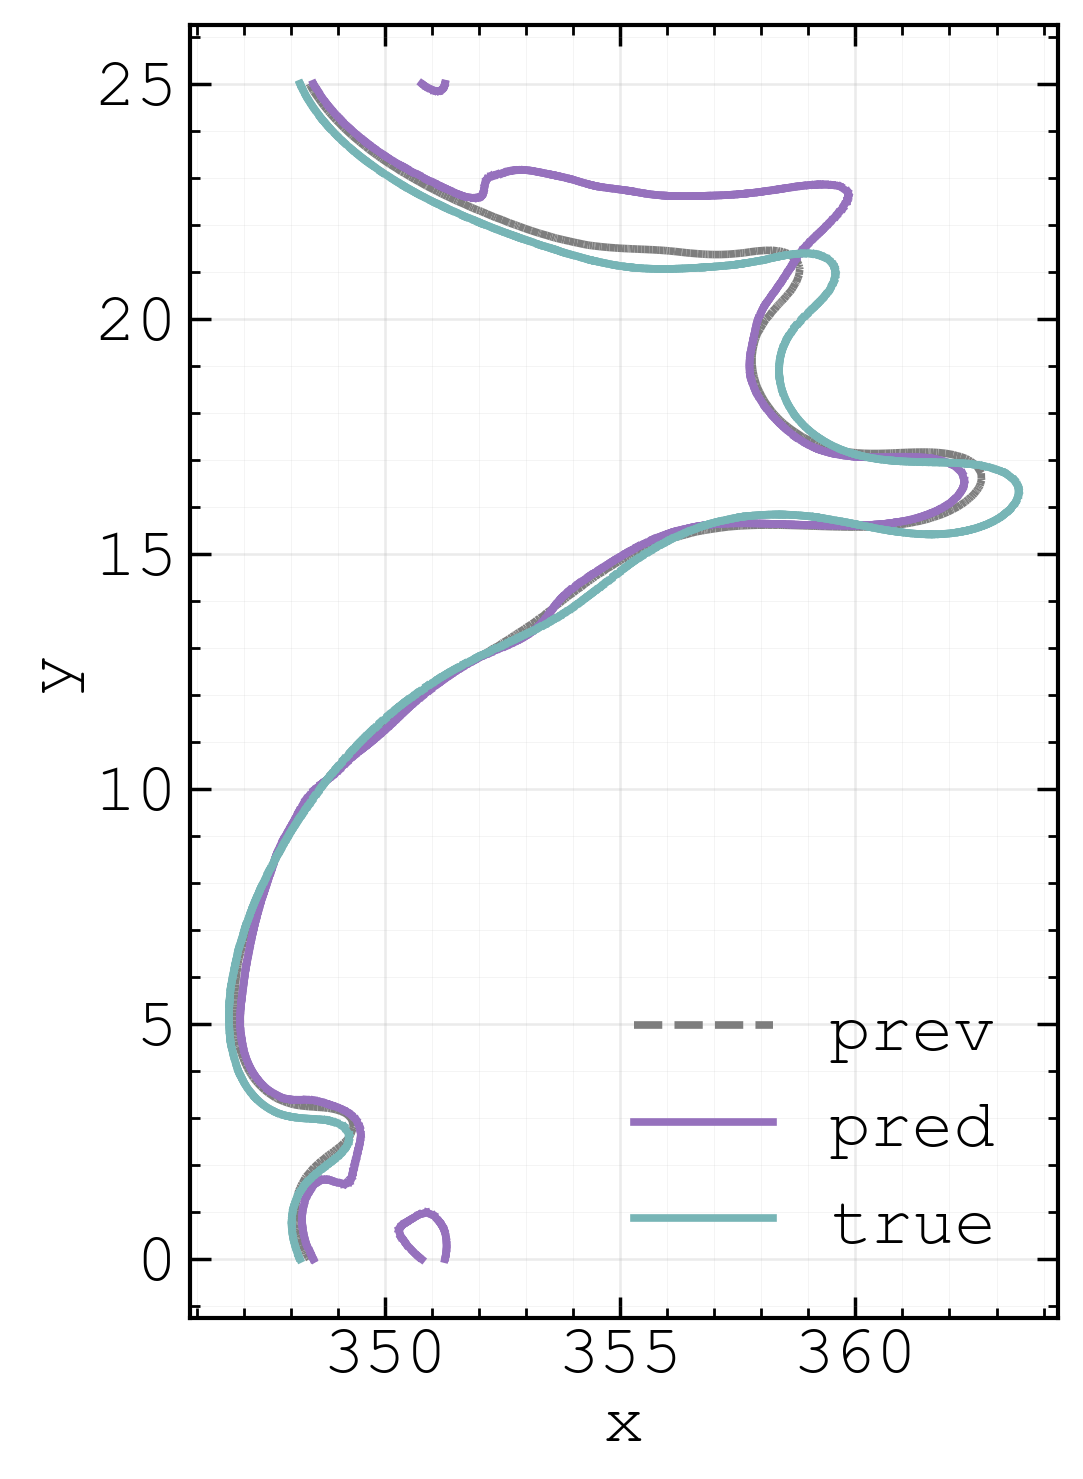

: 

In [ ]:
# --- PyVista isocontour comparison (pred / true / prev) ---
import pyvista as pv
import numpy as np
import matplotlib.pyplot as plt

ISO_VALUE = 3.8  # set desired T isocontour

def _build_ugrid_xy(coords):
    pts = np.column_stack([
        coords[:, 0].astype(float),
        coords[:, 1].astype(float),
        np.zeros(coords.shape[0], dtype=float),
    ])
    poly = pv.PolyData(pts)
    mesh = poly.delaunay_2d()
    if hasattr(mesh, "cast_to_unstructured_grid"):
        return mesh.cast_to_unstructured_grid()
    return mesh

def _extract_isoline(grid, values, iso_value, label):
    if values.shape[0] != grid.n_points:
        raise ValueError(
            f"Scalar length {values.shape[0]} does not match grid points {grid.n_points}."
        )
    g = grid.copy(deep=True)
    g[label] = values
    return g.contour(isosurfaces=[iso_value], scalars=label)

def _contour_segments_xy(poly):
    if poly.n_points == 0:
        return []
    lines = np.asarray(poly.lines)
    if lines.size == 0:
        return []
    pts = np.asarray(poly.points)
    segments = []
    i = 0
    while i < lines.size:
        n = lines[i]
        idx = lines[i + 1 : i + 1 + n]
        segments.append(pts[idx, :2])
        i += n + 1
    return segments

def _plot_segments(ax, segments, *, label, color, linestyle="-", linewidth=2.2):
    if not segments:
        return False
    first = True
    for seg in segments:
        ax.plot(
            seg[:, 0],
            seg[:, 1],
            color=color,
            linestyle=linestyle,
            linewidth=linewidth,
            label=label if first else None,
        )
        first = False
    return True

# Previous (last training) snapshot
x_prev = np.asarray(X[:, -1]).real

# True next snapshot (if available)
snap_true_iso = None
path_true = field_hdf5_path(BASE_DIR, PHI, LAT_SIZE, t_next, POST)
if path_true.exists():
    if "snap_true" in globals():
        snap_true_iso = np.asarray(snap_true).real
    else:
        coords_true_full, snap_true_full = read_field_sorted(path_true, VAR_NAME, SORT_COLS)
        if coords_true_full.shape[0] != coords_ref_full.shape[0]:
            raise ValueError(
                f"True next-step has different full point count: {coords_true_full.shape[0]} vs {coords_ref_full.shape[0]}"
            )
        if COORD_TOL == 0.0:
            same = np.array_equal(coords_true_full, coords_ref_full)
        else:
            same = np.allclose(coords_true_full, coords_ref_full, atol=COORD_TOL, rtol=0.0)
        if not same:
            raise ValueError("Full coordinates changed; cannot compare directly.")
        snap_true_iso = snap_true_full[mask_x]

grid = _build_ugrid_xy(coords_ref)

contour_pred = _extract_isoline(grid, x_next_pred, ISO_VALUE, f"{VAR_NAME}_pred")
segments_pred = _contour_segments_xy(contour_pred)

contour_prev = _extract_isoline(grid, x_prev, ISO_VALUE, f"{VAR_NAME}_prev")
segments_prev = _contour_segments_xy(contour_prev)

segments_true = []
if snap_true_iso is not None:
    contour_true = _extract_isoline(grid, snap_true_iso, ISO_VALUE, f"{VAR_NAME}_true")
    segments_true = _contour_segments_xy(contour_true)

fig = plt.figure(figsize=(7.2, 5.8), dpi=FIG_DPI, constrained_layout=True)
ax = fig.add_subplot(111)

_plot_segments(ax, segments_prev, label="prev", color=COLOR_NEUTRAL, linestyle="--", linewidth=LINE_WIDTH)
_plot_segments(ax, segments_pred, label="pred", color=COLOR_PRED, linestyle="-", linewidth=LINE_WIDTH)
if segments_true:
    _plot_segments(ax, segments_true, label="true", color=COLOR_DATA, linestyle="-", linewidth=LINE_WIDTH)

ax.set_xlabel("x")
ax.set_ylabel("y")
ax.set_aspect("equal", adjustable="box")
style_axes(ax)
ax.legend(frameon=False)

save_plot(fig, f"koopmanae_isocontour_{VAR_NAME}_{ISO_VALUE:g}_xgt{int(X_THESHOLD)}")
plt.show()


In [ ]:
# Summary table of field stats (mean/min/max) for pred/true/prev timesteps
if "x_next_pred" not in globals():
    raise RuntimeError("x_next_pred not found. Run the prediction cell first.")
if "t_next" not in globals():
    raise RuntimeError("t_next not found. Run the prediction cell first.")

t_prev = globals().get("t_prev", t_next - 1)
snap_true = globals().get("snap_true", None)
snap_prev = globals().get("snap_prev", None)

def _field_stats(arr):
    arr = np.asarray(arr)
    arr = arr[np.isfinite(arr)]
    if arr.size == 0:
        return float("nan"), float("nan"), float("nan")
    return float(arr.mean()), float(arr.min()), float(arr.max())

rows = []

def _add_row(label, timestep, arr):
    if arr is None:
        mean = minv = maxv = float("nan")
    else:
        mean, minv, maxv = _field_stats(arr)
    rows.append({
        "step": label,
        "timestep": int(timestep),
        "mean": mean,
        "min": minv,
        "max": maxv,
    })

_add_row("pred", t_next, x_next_pred)
_add_row("true", t_next, snap_true)
_add_row("prev", t_prev, snap_prev)

df_stats = pd.DataFrame(rows, columns=["step", "timestep", "mean", "min", "max"])
print(df_stats.to_string(index=False, float_format=lambda x: f"{x:.6g}"))



step  timestep    mean      min     max
pred       300 2.85636 0.624271 5.80987
true       300 2.86155        1   5.153
prev       299 2.85821        1 5.15336


: 